### loading packages

In [37]:
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

### loading data

In [38]:
zf = zipfile.ZipFile('../Data/Base.csv.zip') 
df = pd.read_csv(zf.open('Base.csv'))

In [39]:
df.shape

(1000000, 32)

In [40]:
df.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [41]:
df['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

### data cleaning

The column __device_fraud_count__ is useless, and therefore drop it.

In [42]:
df = df.drop(['device_fraud_count'], axis=1) 

Delete missing data (-1)

In [43]:
df = df[df.bank_months_count != -1]
df = df[df.session_length_in_minutes != -1]
df = df[df.device_distinct_emails_8w != -1] 

In [44]:
df.shape

(745515, 31)

In [45]:
df['fraud_bool'].value_counts()

0    738632
1      6883
Name: fraud_bool, dtype: int64

In [46]:
df=df.reset_index(drop=True)

#### OverSample

In [47]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

##### Set categorical variables(exclude response 'fraud_bool')

In [48]:
cate_var = ['payment_type','employment_status','housing_status',
                     'source','device_os','email_is_free','phone_home_valid',
                     'phone_mobile_valid','has_other_cards','foreign_request',
                     'keep_alive_session','month']

In [32]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(sparse=False)
# one_hot_encoded_data = encoder.fit_transform(df[cate_var])
# columns = encoder.get_feature_names_out(cate_var)
# one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data, columns=columns)
# df_resampled_encoder = pd.concat([df.drop(cate_var,axis=1), one_hot_encoded_df],axis=1)
# print(df.shape[0])
# print(df_resampled_encoder.shape[0])
# # one_hot_encoded_df.shape
# # df.drop(cate_var,axis=1).shape

/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


745515
936144


In [49]:
from sklearn.preprocessing import OneHotEncoder

# 初始化 OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# 对分类变量进行 one-hot 编码
one_hot_encoded_data = encoder.fit_transform(df[cate_var])

print("编码后行数：", one_hot_encoded_data.shape[0])

# 创建编码后的 DataFrame
columns = encoder.get_feature_names_out(cate_var)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data, columns=columns)

# 将编码后的 DataFrame 添加回原始数据集
df_resampled_encoder = pd.concat([df.drop(cate_var, axis=1), one_hot_encoded_df], axis=1)

print("合并后行数：", df_resampled_encoder.shape[0])
print("去除分类变量后行数：",df.drop(cate_var, axis=1).shape[0])
print("one_hot_encoded_data:",one_hot_encoded_data.shape[0])

/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


编码后行数： 745515
合并后行数： 745515
去除分类变量后行数： 745515
one_hot_encoded_data: 745515


In [50]:
df = df_resampled_encoder
df.shape

(745515, 65)

In [58]:
X = df.drop('fraud_bool',axis=1)
y = df['fraud_bool']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.value_counts())

(521860, 64)
0    517084
1      4776
Name: fraud_bool, dtype: int64


In [52]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [57]:
y_train_resampled.value_counts()

0    517084
1    517084
Name: fraud_bool, dtype: int64

In [59]:
X_train = X_train_resampled
y_train = y_train_resampled

### Model

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

#### KNN

In [61]:
from sklearn.neighbors import KNeighborsClassifier

In [62]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 31), 'weights': ['uniform', 'distance']}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train[:3000], y_train[:3000])

best_knn_params = grid_search.best_params_
best_knn_estimator = grid_search.best_estimator_

print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'n_neighbors': 1, 'weights': 'uniform'}


In [63]:
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(X_train,y_train)
y_knn_pred = best_knn_model.predict(X_test)
y_knn_pred_proba = best_knn_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[211607   9941]
 [  1946    161]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    221548
           1       0.02      0.08      0.03      2107

    accuracy                           0.95    223655
   macro avg       0.50      0.52      0.50    223655
weighted avg       0.98      0.95      0.96    223655


Accuracy Score:
0.94685117703606


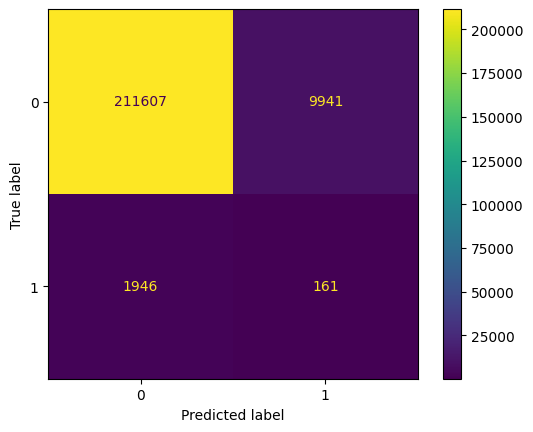

In [64]:
cm = confusion_matrix(y_test, y_knn_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_knn_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_knn_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_knn_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_knn_pred))

#### GBDT

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

In [66]:
gbdt = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(gbdt, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train[:3000], y_train[:3000])

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [67]:
best_gbdt_params = grid_search.best_params_
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 1.0}


In [68]:
best_gbdt_model = GradientBoostingClassifier(**best_gbdt_params)
best_gbdt_model.fit(X_train,y_train)
y_gbdt_pred = best_gbdt_model.predict(X_test)
y_gbdt_pred_proba = best_gbdt_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[219735   1813]
 [  1780    327]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    221548
           1       0.15      0.16      0.15      2107

    accuracy                           0.98    223655
   macro avg       0.57      0.57      0.57    223655
weighted avg       0.98      0.98      0.98    223655


Accuracy Score:
0.9839350785808499


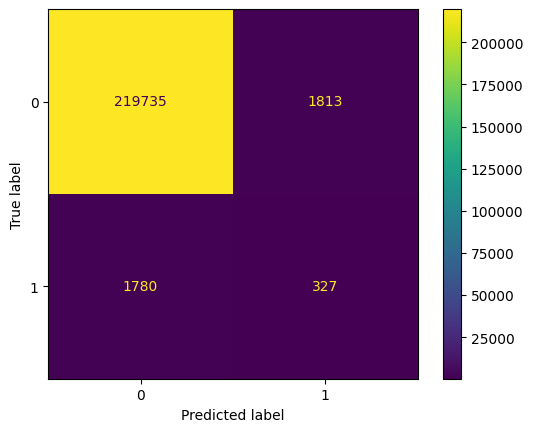

In [69]:
cm = confusion_matrix(y_test, y_gbdt_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_gbdt_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_gbdt_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_gbdt_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_gbdt_pred))

#### XGBoost

In [70]:
from xgboost import XGBClassifier


In [71]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train[:3000], y_train[:3000])


/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [72]:
best_xgb_params = grid_search.best_params_
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.9}


In [73]:
best_xgb_model = XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train,y_train)
y_xgb_pred = best_xgb_model.predict(X_test)
y_xgb_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[217374   4174]
 [  1609    498]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    221548
           1       0.11      0.24      0.15      2107

    accuracy                           0.97    223655
   macro avg       0.55      0.61      0.57    223655
weighted avg       0.98      0.97      0.98    223655


Accuracy Score:
0.9741432116429322


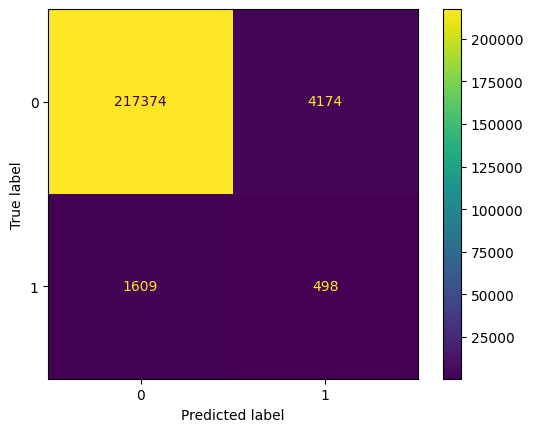

In [74]:
cm = confusion_matrix(y_test, y_xgb_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_xgb_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_xgb_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_xgb_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_xgb_pred))

#### MLP

In [75]:
from sklearn.neural_network import MLPClassifier

In [76]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'batch_size': [32, 64, 128],
    'max_iter': [100, 200, 300],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.01],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.1]
}

mlp_model = MLPClassifier(random_state=42)
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, 
                           scoring='roc_auc', n_jobs=64)
grid_search.fit(X_train[:3000], y_train[:3000])

/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
 

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=64,
             param_grid={'activation': ['relu', 'tanh'], 'alpha': [0.01],
                         'batch_size': [32, 64, 128],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'learning_rate': ['adaptive'],
                         'learning_rate_init': [0.1],
                         'max_iter': [100, 200, 300], 'solver': ['adam']},
             scoring='roc_auc')

In [77]:
best_mlp_params = grid_search.best_params_
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'activation': 'tanh', 'alpha': 0.01, 'batch_size': 128, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'max_iter': 100, 'solver': 'adam'}


In [78]:
best_mlp_model = MLPClassifier(**best_mlp_params)
best_mlp_model.fit(X_train,y_train)
y_mlp_pred = best_mlp_model.predict(X_test)
y_mlp_pred_proba = best_mlp_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[     0 221548]
 [     0   2107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    221548
           1       0.01      1.00      0.02      2107

    accuracy                           0.01    223655
   macro avg       0.00      0.50      0.01    223655
weighted avg       0.00      0.01      0.00    223655


Accuracy Score:
0.00942075965214281


/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

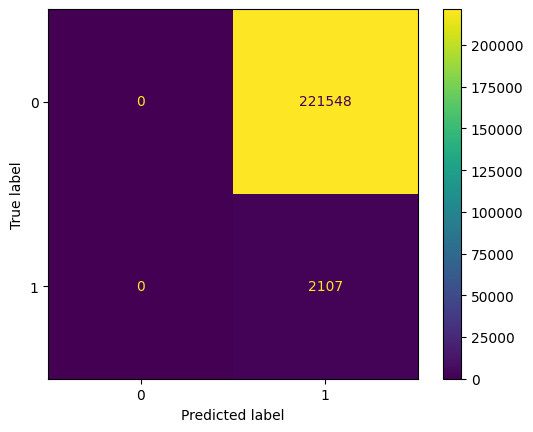

In [79]:
cm = confusion_matrix(y_test, y_mlp_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_mlp_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_mlp_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_mlp_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_mlp_pred))